# Using the DeCam images to subtract DP1 images

**Description:** This notebook demonstrates how to perform image subtraction on LSST data using DECam templates

**author:** Yize Dong

**email:** yize.dong@cfa.harvard.edu



## load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from lsst_decam_subtraction.subtraction import lsst_decam_data_load, perform_image_subtraction
from lsst_decam_subtraction.lsst_utils import query_lsst_visits, astropy_world_to_pixel, forced_phot
from lsst.daf.butler import Butler
from astropy.visualization import PercentileInterval, ImageNormalize

In [2]:
butler = Butler("dp1", collections="LSSTComCam/DP1")

## query images
Find images that are within the timespan and contain the source we are interested

In [3]:
ra = 58.335054 
dec = -48.750303
band = 'g'
time1 = '2024-12-01'
time2 = '2024-12-10'
data_query = query_lsst_visits(butler=butler, ra=ra, dec=dec, band=band, time1=time1, time2=time2)

In [4]:
data_query[1]

DatasetRef(DatasetType('visit_image', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF), {instrument: 'LSSTComCam', detector: 2, visit: 2024120800423, band: 'g', day_obs: 20241208, physical_filter: 'g_01'}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=4a48bd19-7261-4665-bdd8-d8c5528bfd0b)

In [5]:
visit_image = butler.get(data_query[1])

## prepare for the difference imaging step
This will download the templates from the DES-DR2, calibrate the WCS of both the science and the template images, and align the template image with the science image. You can choose to download either the Gaia or the DES catalog.

INFO: Query finished. [astroquery.utils.tap.core]


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

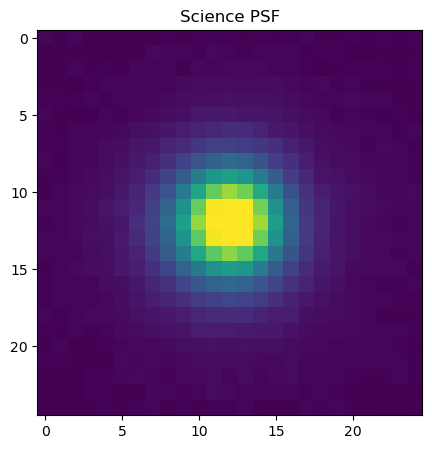

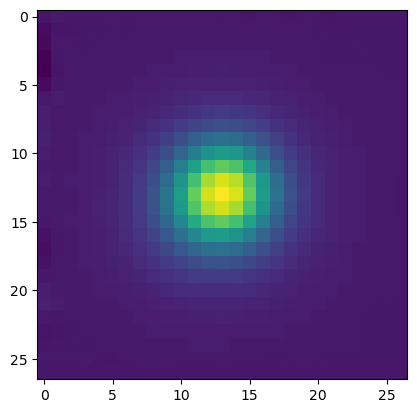

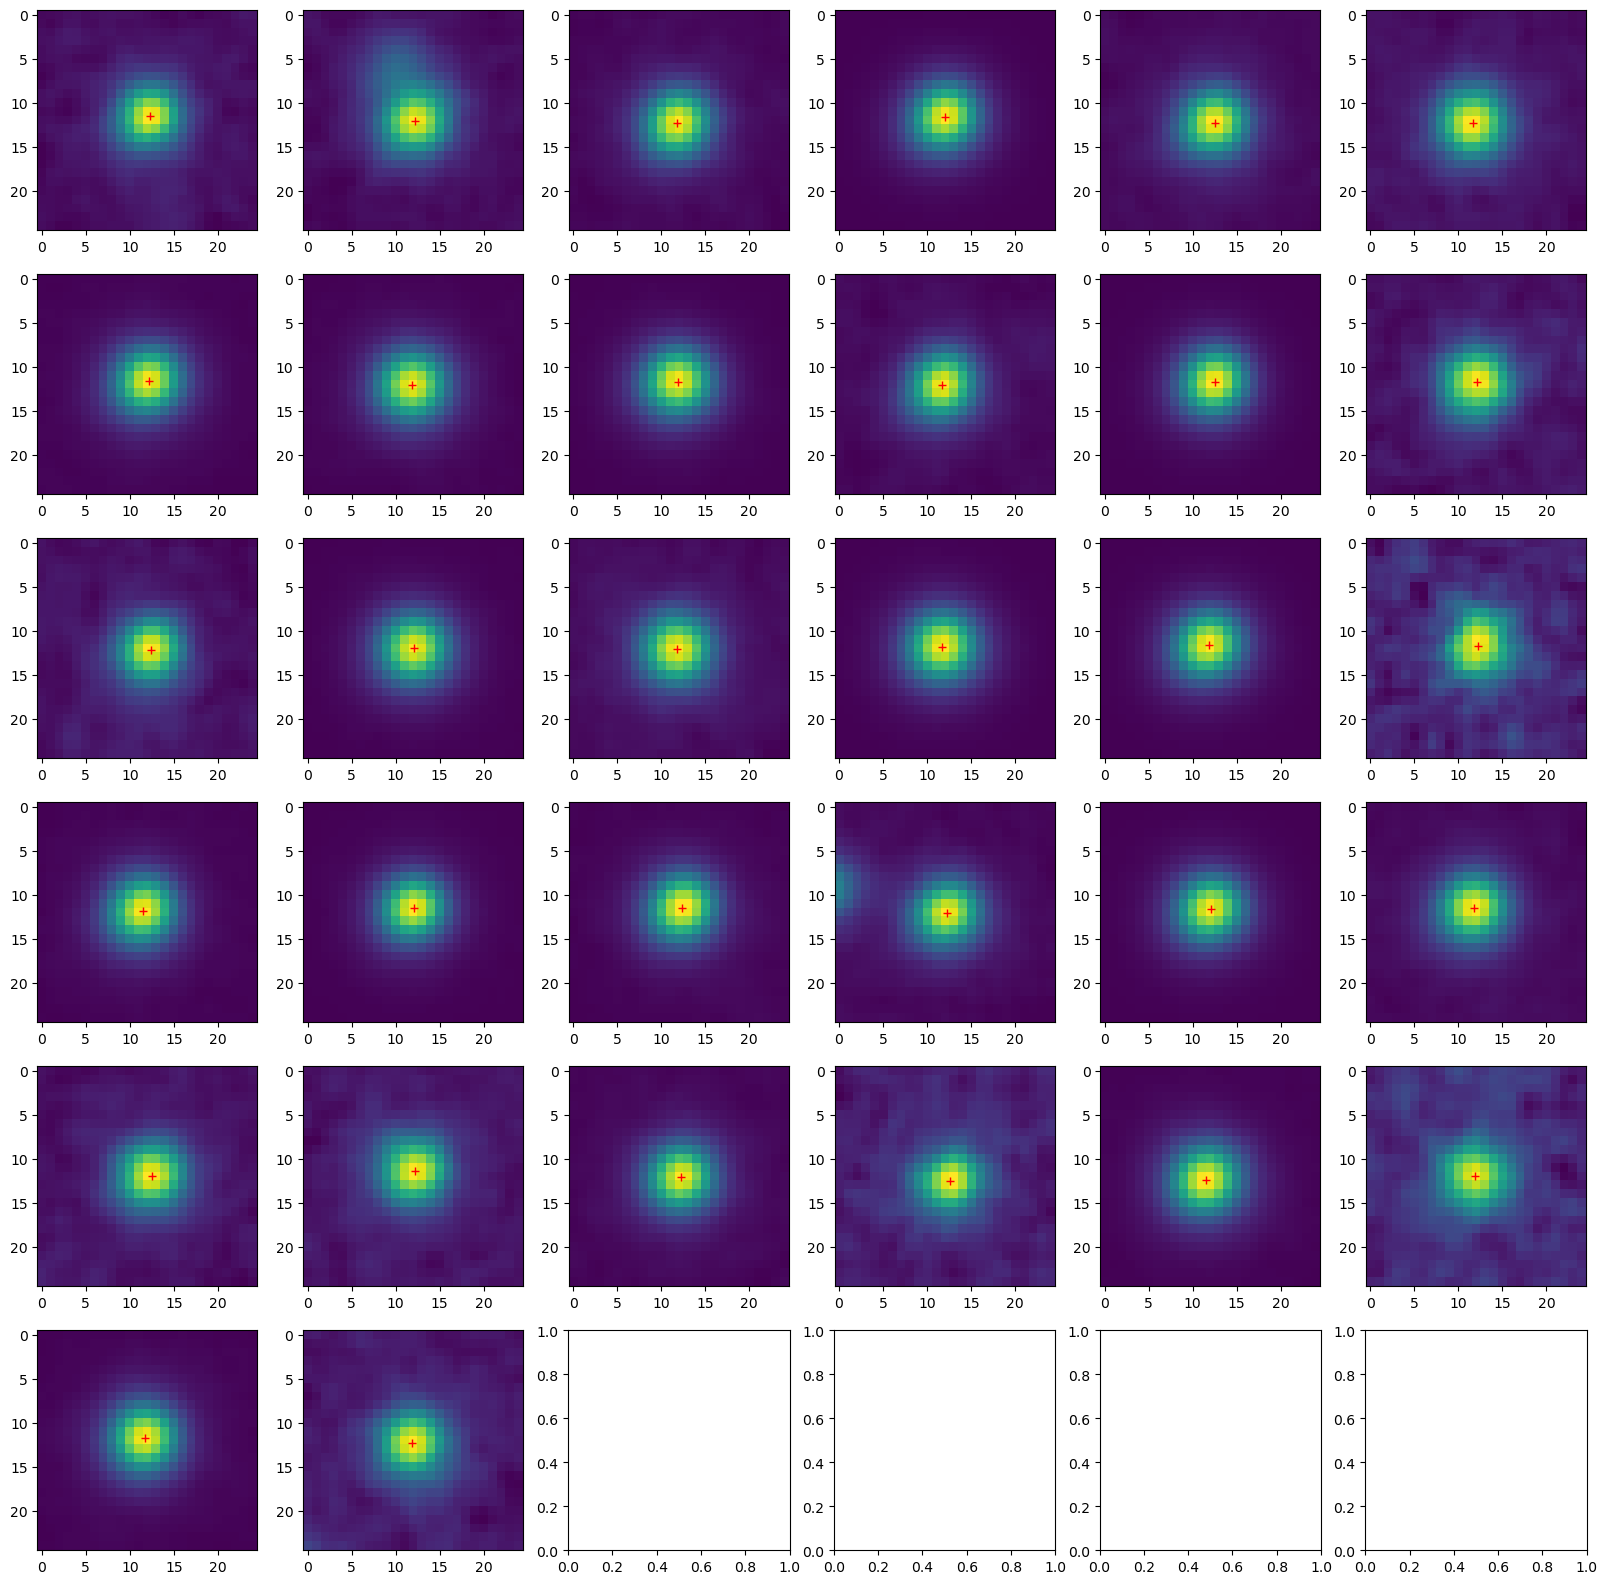

In [6]:
scidata, refdata, sci_psf, ref_psf, ref_global_bkg = lsst_decam_data_load(visit_image, ra = ra, dec = dec, download_DES_temp=True, show=True, 
                                                          cutout=True, cutout_size=2000, reference_catalog='gaia', reference_mag1=17, reference_mag2=21,
                                                                          save_intermediate=False, save_original_temp=True)

## image subtraction
This will perform the image subtration and return the aligned template, final difference image, and the PSF for the photometry stage. This can take a few mins.

In [7]:
refdata_aligned, normalized_difference, diff_psf = perform_image_subtraction(scidata, refdata, sci_psf, ref_psf, ref_global_bkg,
                          save_diff=False, show=False, sigma_cut=5, max_iterations=3)

[Memory Watch] Memory usage is 16.71 GB, waiting to drop below 15.00 GB...
[Memory Watch] Memory usage is 16.71 GB, waiting to drop below 15.00 GB...
[Memory Watch] Memory usage is 16.71 GB, waiting to drop below 15.00 GB...
[Memory Watch] Memory usage is 16.36 GB, waiting to drop below 15.00 GB...


Text(0.5, 1.0, 'difference')

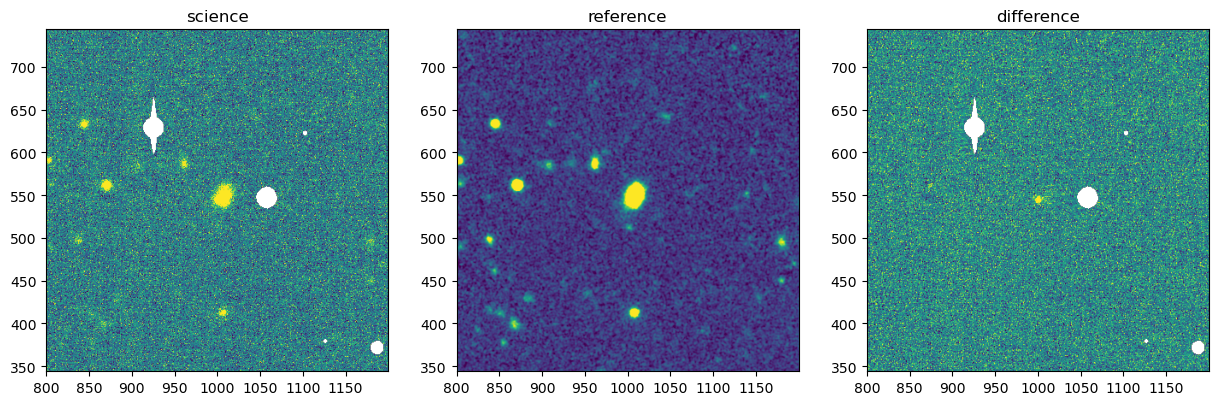

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
norm = ImageNormalize(scidata.data, PercentileInterval(98))
ax1.imshow(scidata, norm=norm)
_x, _y = astropy_world_to_pixel(ra, dec, scidata.wcs)
#ax1.plot(x, y, marker='o', mec='r', mfc='none', ls='none')
ax1.set_xlim(_x-200, _x+200)
ax1.set_ylim(_y-200, _y+200)
ax1.set_title('science')

norm = ImageNormalize(refdata.data, PercentileInterval(98))
ax2.imshow(refdata, norm=norm)
_x, _y = astropy_world_to_pixel(ra, dec, scidata.wcs)
#ax1.plot(x, y, marker='o', mec='r', mfc='none', ls='none')
ax2.set_xlim(_x-200, _x+200)
ax2.set_ylim(_y-200, _y+200)
ax2.set_title('reference')

norm = ImageNormalize(normalized_difference.data, PercentileInterval(98))
ax3.imshow(normalized_difference, norm=norm)
ax3.set_xlim(_x-200, _x+200)
ax3.set_ylim(_y-200, _y+200)
ax3.set_title('difference')

## Do photometry on the difference image at the provided position

In [9]:
flux_njy, flux_err, mag, mag_err, upper_limit = forced_phot(ra, dec, normalized_difference, scidata.wcs, diff_psf)
print(f"Flux: {flux_njy:.2f} ± {flux_err:.2f} nJy\nMag: {mag:.2f} ± {mag_err:.2f}\nUpper limit: {upper_limit:.2f}")

Flux: 4549.66 ± 210.63 nJy
Mag: 22.26 ± 0.05
Upper limit: 23.84
